In [1]:
import os
import geopandas as gpd
from blocksnet import GraphGenerator
import blocksnet
from blocksnet.preprocessing import DataGetter, AggregateParameters

from blocksnet.models import City
import pandas as pd
from shapely import Point


import warnings
warnings.filterwarnings('ignore')



local_crs = 32636
example_data_path = "./my_data"
example_data_path_for_me = "./my_data/examples"

In [2]:
blocks = gpd.read_parquet(os.path.join(example_data_path, 'blocks_cutter_result.parquet')).to_crs(local_crs)
blocks.head()

,geometry,id,landuse
0,"POLYGON ((303022.702 6675775.060, 303022.795 6...",0,no_dev_area
1,"POLYGON ((303012.608 6675801.562, 303012.586 6...",1,no_dev_area
2,"POLYGON ((303064.339 6675806.849, 303064.442 6...",2,no_dev_area
3,"POLYGON ((303428.643 6675829.284, 303425.776 6...",3,buildings
4,"POLYGON ((303429.370 6675800.664, 303429.236 6...",4,no_dev_area


In [3]:
houses = gpd.read_file(os.path.join(example_data_path, "house_points.geojson")).to_crs(local_crs)
houses.head()

,avg_m2_price_rent,mean_price_rent,P_clinic,P_hospitals,P_kindergarten,P_mfc,P_schools,accs_time,log_accs_time,Iq,P_avg,Idx,geometry
0,1190.476190,25000.0,1,1,1.0,0.0,1.0,40.8,1.61,0.55,0.8,0.675,POINT (349844.614 6646516.903)
1,537.634409,30000.0,1,1,1.0,0.0,1.0,83.0,1.92,0.37,0.8,0.585,POINT (349100.178 6657288.179)
2,708.573345,44666.0,1,1,1.0,0.0,1.0,10.0,1.00,0.50,0.8,0.650,POINT (342768.230 6637807.041)
3,538.461538,35000.0,1,1,1.0,0.0,1.0,10.0,1.00,0.61,0.8,0.705,POINT (342687.422 6637725.165)
4,2000.000000,32000.0,1,1,0.0,1.0,0.0,39.5,1.60,0.42,0.6,0.510,POINT (350044.641 6646061.322)


In [4]:
houses['Iq'].describe()

count    1505.000000
mean        0.405654
std         0.088457
min         0.300000
25%         0.340000
50%         0.380000
75%         0.490000
max         0.790000
Name: Iq, dtype: float64

In [5]:
houses = houses.loc[houses['Iq'] > 0.3]
houses['Iq'].describe()

count    1404.000000
mean        0.413255
std         0.086756
min         0.310000
25%         0.350000
50%         0.380000
75%         0.490000
max         0.790000
Name: Iq, dtype: float64

In [6]:
houses_pol = houses.copy()
houses_pol['geometry'] = houses['geometry'].apply(lambda x: x.buffer(0.001))  # Преобразование точек в небольшие полигоны

# Выполнение пространственного объединения для определения, в каких кварталах находятся дома
overlay = gpd.overlay(blocks, houses_pol, how="intersection")

unique_blocks_ids = overlay["id"].unique()

blocks_with_houses = blocks[blocks["id"].isin(unique_blocks_ids)]
blocks_with_houses.reset_index(drop= True, inplace= True )
blocks_with_houses.head()

,geometry,id,landuse
0,"POLYGON ((337030.970 6638333.827, 337031.347 6...",2854,selected_area
1,"POLYGON ((339076.063 6636586.371, 339075.615 6...",3326,no_dev_area
2,"POLYGON ((338883.944 6636688.475, 338884.040 6...",3331,buildings
3,"POLYGON ((339697.103 6635459.892, 339690.468 6...",3503,no_dev_area
4,"POLYGON ((340239.631 6635418.232, 340239.373 6...",3504,no_dev_area


In [7]:
blocks_with_houses.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  241 non-null    geometry
 1   id        241 non-null    int64   
 2   landuse   241 non-null    object  
dtypes: geometry(1), int64(1), object(1)
memory usage: 5.8+ KB


In [8]:
# blocks_with_houses.explore()

In [9]:
getter = DataGetter(blocks=blocks_with_houses)

In [10]:
# Создание графа транспортной доступности 
# +
# Создание матрицы доступности и сохранение ее в пикл

'''
city_geometry = gpd.GeoDataFrame([{'geometry': blocks_with_houses.unary_union.convex_hull}]).set_crs(local_crs)
intermodal_graph = GraphGenerator(city_geometry=city_geometry, local_crs=local_crs).get_graph('intermodal')
accessibility_matrix = getter.get_accessibility_matrix(intermodal_graph)
accessibility_matrix.to_pickle(os.path.join(example_data_path, "data_getter_matrix.pickle"))
'''

'\ncity_geometry = gpd.GeoDataFrame([{\'geometry\': blocks_with_houses.unary_union.convex_hull}]).set_crs(local_crs)\nintermodal_graph = GraphGenerator(city_geometry=city_geometry, local_crs=local_crs).get_graph(\'intermodal\')\naccessibility_matrix = getter.get_accessibility_matrix(intermodal_graph)\naccessibility_matrix.to_pickle(os.path.join(example_data_path, "data_getter_matrix.pickle"))\n'

In [11]:
# city_geometry = gpd.GeoDataFrame([{'geometry': blocks_with_houses.unary_union.convex_hull}]).set_crs(local_crs)
# intermodal_graph = GraphGenerator(city_geometry=city_geometry, local_crs=local_crs).get_graph('intermodal')
# gg = blocksnet.preprocessing.graph_generator.GraphGenerator(city_geometry = city_geometry)
# gg.plot(intermodal_graph)

In [12]:
buildings = gpd.read_parquet(os.path.join(example_data_path, "all_buildings_spb.parquet")).to_crs(local_crs)
buildings.head()

,building_id,building_area,living_area,storeys_count,population_balanced,is_living,geom
0,1,145.871,NaN,2.0,29,False,"MULTIPOLYGON (((302685.489 6676297.801, 302689..."
1,2,139.242,NaN,NaN,0,False,"POLYGON ((302929.515 6676138.437, 302932.880 6..."
2,3,390.244,NaN,NaN,0,True,"MULTIPOLYGON (((303042.071 6676392.771, 303043..."
3,4,579.998,405.998,1.0,0,True,"MULTIPOLYGON (((303078.321 6676453.630, 303091..."
4,5,695.979,915.400,1.0,151,False,"MULTIPOLYGON (((303246.716 6676494.615, 303278..."


In [13]:
# Выполнение пространственного объединения для определения нужных домов
overlay = gpd.overlay(houses_pol, buildings, how="intersection")

unique_buildings_ids = overlay["building_id"].unique()

buildings = buildings[buildings["building_id"].isin(unique_buildings_ids)]

# Для того, чтобы сработал aggregate_blocks_info
buildings.rename(columns = {'geom': 'geometry'}, inplace = True )
buildings['is_living'] = True
buildings = buildings.set_geometry('geometry')
buildings['total_area'] = buildings['geometry'].area
buildings['living_area_pyatno'] = buildings['geometry'].area
buildings.head()

,building_id,building_area,living_area,storeys_count,population_balanced,is_living,geometry,total_area,living_area_pyatno
24277,24510,1332.330,6548.3,9.0,188,True,"MULTIPOLYGON (((338091.065 6638065.940, 338095...",1332.122430,1332.122430
24886,25123,381.492,692.5,3.0,20,True,"MULTIPOLYGON (((338565.066 6637860.958, 338567...",381.430031,381.430031
25425,25664,339.437,3735.0,15.0,107,True,"MULTIPOLYGON (((339056.394 6637144.906, 339065...",339.380680,339.380680
25525,25764,439.492,4833.9,15.0,139,True,"MULTIPOLYGON (((339132.623 6637136.638, 339139...",439.419333,439.419333
25550,25789,804.020,3525.1,5.0,101,True,"MULTIPOLYGON (((339135.481 6636807.653, 339136...",803.886508,803.886508


In [14]:
isinstance(buildings, gpd.GeoDataFrame)

True

In [15]:
greenings = gpd.GeoDataFrame([{'current_green_area': 0, 'current_green_capacity': 0, 'geometry': Point(0,0)}]).set_crs(local_crs)
parkings = gpd.GeoDataFrame([{'current_parking_capacity': 0, 'geometry': Point(0,0)}]).set_crs(local_crs)
greenings.head()

,current_green_area,current_green_capacity,geometry
0,0,0,POINT (0.000 0.000)


In [16]:
# Агрегирование данных
# +
# Сохранение результата в паркет
'''
aggr_params = AggregateParameters(
  buildings=buildings,
  greenings=greenings,
  parkings=parkings
)

aggregated_blocks = getter.aggregate_blocks_info(params=aggr_params)
aggregated_blocks.head()

# Сохраняем агрегированные кварталы
aggregated_blocks.to_parquet(os.path.join(example_data_path, "data_getter_blocks.parquet"))
'''

'\naggr_params = AggregateParameters(\n  buildings=buildings,\n  greenings=greenings,\n  parkings=parkings\n)\n\naggregated_blocks = getter.aggregate_blocks_info(params=aggr_params)\naggregated_blocks.head()\n\n# Сохраняем агрегированные кварталы\naggregated_blocks.to_parquet(os.path.join(example_data_path, "data_getter_blocks.parquet"))\n'

In [17]:
# load aggregated info we have
aggregated_blocks = gpd.read_parquet(os.path.join(example_data_path, "data_getter_blocks.parquet"))
accessibility_matrix = pd.read_pickle(os.path.join(example_data_path, "data_getter_matrix.pickle"))

In [18]:
city_model = City(
  blocks_gdf=aggregated_blocks, 
  matrix=accessibility_matrix, 
)

In [19]:
# load data required for service graphs creation
schools = gpd.read_file(os.path.join(example_data_path, "schools.geojson")).to_crs(local_crs)
kindergartens = gpd.read_file(os.path.join(example_data_path, "kindergartens.geojson")).to_crs(local_crs)
multifunctional_centers = gpd.read_file(os.path.join(example_data_path, "multifunctional_centers.geojson")).to_crs(local_crs)
hospitals = gpd.read_file(os.path.join(example_data_path, "hospitals.geojson")).to_crs(local_crs)
policlinics = gpd.read_file(os.path.join(example_data_path, "policlinics.geojson")).to_crs(local_crs)

# services should be specified as a dictionary
services = {"schools": schools, "kindergartens": kindergartens, "multifunctional_centers": multifunctional_centers,
            "hospitals": hospitals, "policlinics": policlinics}

In [20]:
for service_type, gdf in services.items():
  city_model.update_layer(service_type, gdf)

In [25]:
city_model.to_pickle(os.path.join(example_data_path, 'city_model.pickle'))

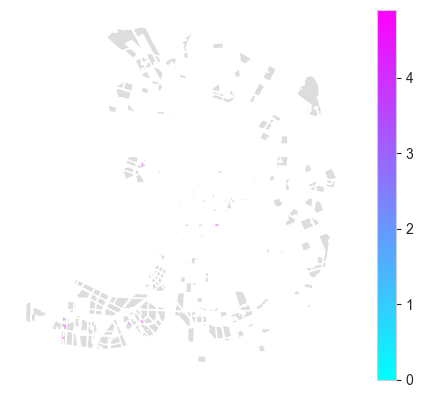

In [26]:
city_model.plot()